In [ ]:
import pandas as pd
res_cifar10 = pd.read_csv("results/results_cifar10.csv")
res_cifar10_large = pd.read_csv("results/results_cifar10_large.csv")

In [4]:
res_cifar10

,Date,Model_Type,Attack,Accuracy,Epsilon,Alpha,Steps,Dataset
0,2025-12-02 14:00:00,Classique,Clean,72.76,0.0314,0.0078,1,CIFAR10
1,2025-12-02 14:00:00,Robuste,Clean,50.33,0.0314,0.0078,1,CIFAR10
2,2025-12-02 14:00:00,Classique,PGD,0.01,0.0314,0.0078,20,CIFAR10
3,2025-12-02 14:00:00,Robuste,PGD,29.52,0.0314,0.0078,20,CIFAR10


In [5]:
res_cifar10_large

,Date,Model_Type,Attack,Accuracy,Epsilon,Alpha,Steps,Dataset
0,2025-12-02 14:15:00,Classique,Clean,91.32,0.0314,0.0078,1,CIFAR10
1,2025-12-02 14:15:00,Robuste,Clean,29.15,0.0314,0.0078,1,CIFAR10
2,2025-12-02 14:15:00,Classique,PGD,14.74,0.0314,0.0078,20,CIFAR10
3,2025-12-02 14:15:00,Robuste,PGD,35.78,0.0314,0.0078,20,CIFAR10


Le script s'exécute sur le périphérique: cpu


/Users/maeltremouille/Documents/Cours/ENSAE/3A/Advanced ML/Advanced_machine_learning.nosync/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Lancement de l'attaque PGD (steps=10, ε=0.0314, α=0.0078)...
Attaque terminée.


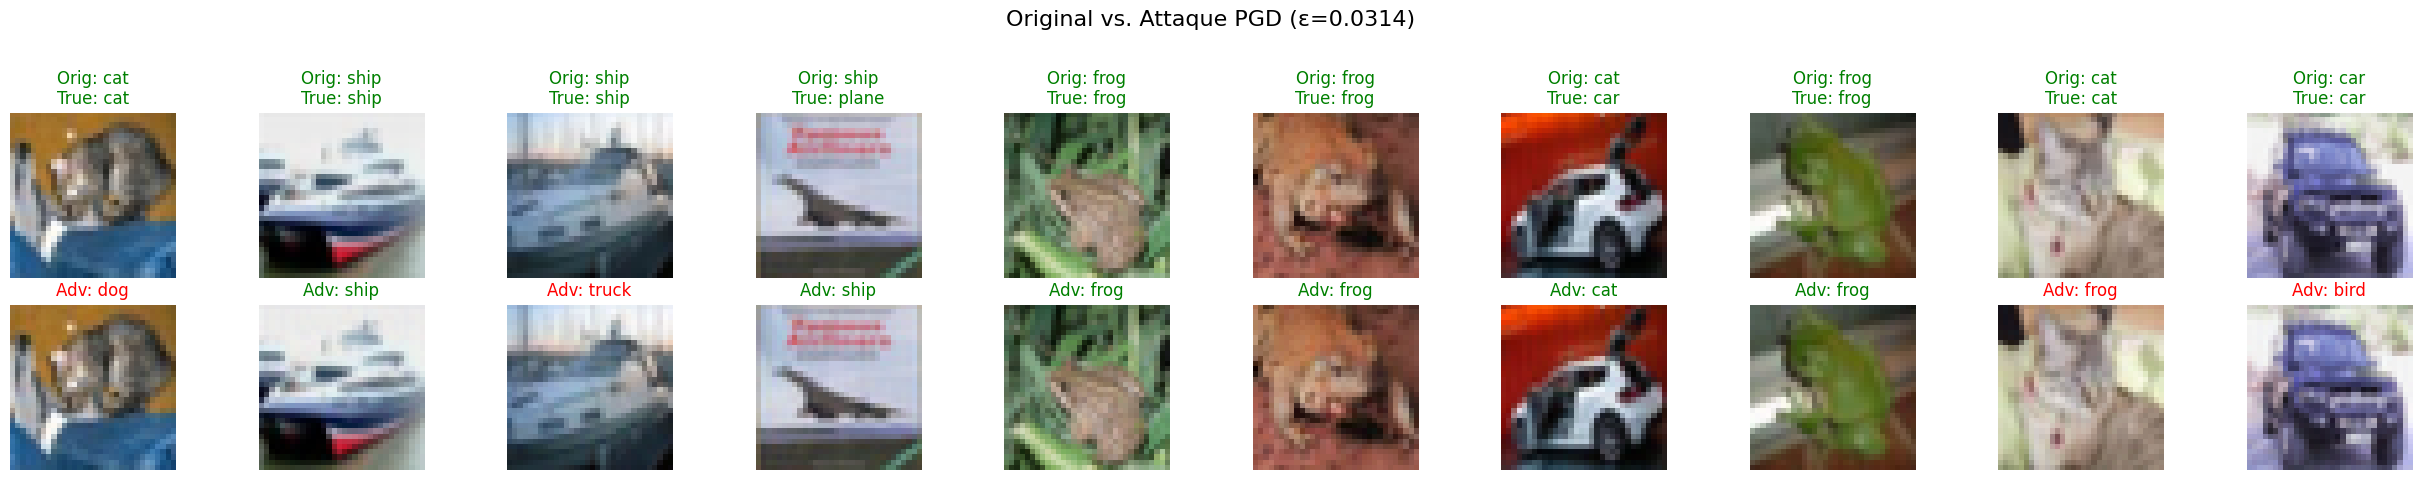

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Importations Adaptées à votre Structure ---

# Importe la fonction get_cifar10_loaders depuis 'services/dataloaders/cifar10_loader.py'
try:
    from services.dataloaders.cifar10_loader import get_cifar10_loaders
except ImportError:
    print("Erreur: Impossible d'importer get_cifar10_loaders. Vérifiez le chemin.")
    exit()

# Importe le modèle CIFAR-10 (SimpleCIFAR10CNN) depuis 'services/models/cifar10_model.py'
try:
    from services.models.cifar10_model import SimpleCIFAR10CNN 
except ImportError:
    print("Erreur: Impossible d'importer SimpleCIFAR10CNN. Assurez-vous d'avoir 'cifar10_model.py'.")
    exit()

# Importe la fonction d'attaque PGD depuis 'services/pgd_attack.py'
try:
    from services.pgd_attack import pgd_attack 
except ImportError:
    print("Erreur: Impossible d'importer pgd_attack. Vérifiez le chemin 'services/pgd_attack.py'.")
    exit()


# --- 2. Paramètres de Configuration ---
# Vérifie si CUDA est disponible pour utiliser le GPU, sinon CPU. (Plus robuste que la ligne précédente)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_IMAGES = 10 
BATCH_SIZE = 16 
# Chemin vers un modèle 'clean' CIFAR-10
MODEL_PATH = "checkpoints/cifar_10/cifar10_clean.pth" 

# Paramètres de l'Attaque PGD
EPSILON = 8/255.0  # Marge maximale (L-inf)
ALPHA = 2/255.0    # Taille du pas
NUM_STEPS = 10     # Nombre d'itérations


# --- 3. Fonctions Utiles (Dés-normalisation et Affichage) ---

# ATTENTION CORRECTION : Ces valeurs correspondent aux 'stats' utilisées dans get_cifar10_loaders
CIFAR10_MEAN = np.array([0.4914, 0.4822, 0.4465])
# Écart-type corrigé (0.2023, 0.1994, 0.2010) pour correspondre au loader
CIFAR10_STD = np.array([0.2023, 0.1994, 0.2010]) 

def unnormalize(tensor, mean=CIFAR10_MEAN, std=CIFAR10_STD):
    """Inverse la normalisation pour l'affichage."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        # Opérations inverses de la normalisation : démultiplication puis désoustraction
        t.mul_(s).add_(m)
    return tensor

def imshow(img, ax, title=None):
    """Affiche un tenseur PyTorch comme une image sur un axe Matplotlib."""
    # Dés-normalise et convertit de [C, H, W] à [H, W, C]
    npimg = unnormalize(img.cpu()).numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)).clip(0, 1))
    if title:
        ax.set_title(title)
    ax.axis('off')

# --- 4. Fonction Principale ---

def visualize_pgd_attack():
    print(f"Le script s'exécute sur le périphérique: {DEVICE}")
    
    # 4.1. Chargement des Données
    
    # CORRECTION CRITIQUE: get_cifar10_loaders() retourne (train_loader, test_loader)
    # On appelle sans 'train=False' et on déballe le tuple pour prendre uniquement le testloader.
    try:
        _, testloader = get_cifar10_loaders(batch_size=BATCH_SIZE)
    except Exception as e:
        print(f"Erreur lors de l'obtention des DataLoaders. Détails: {e}")
        return
        
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # 4.2. Initialisation du Modèle et de la Loss
    # Utilise la classe SimpleCIFAR10CNN
    model = SimpleCIFAR10CNN().to(DEVICE)
    
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    except Exception as e:
        print(f"Erreur critique: Impossible de charger le modèle depuis {MODEL_PATH}. Vérifiez le chemin et l'architecture du modèle.")
        return
        
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    # 4.3. Extraction du Lot et Exécution de l'Attaque
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    # Exécuter l'attaque
    print(f"Lancement de l'attaque PGD (steps={NUM_STEPS}, ε={EPSILON:.4f}, α={ALPHA:.4f})...")
    
    # Bornes de clamp pour l'attaque PGD (doit respecter l'espace normalisé)
    clamp_min = torch.min(images).item()
    clamp_max = torch.max(images).item()
    
    images_adv = pgd_attack(
        model,
        loss_fn,
        images,
        labels,
        epsilon=EPSILON,
        alpha=ALPHA,
        num_steps=NUM_STEPS,
        clamp_min=clamp_min,
        clamp_max=clamp_max,
    )
    print("Attaque terminée.")
    
    # 4.4. Affichage des Résultats
    
    # Utilise uniquement les premières NUM_IMAGES
    images = images[:NUM_IMAGES]
    images_adv = images_adv[:NUM_IMAGES]
    labels = labels[:NUM_IMAGES]
    
    fig, axes = plt.subplots(2, NUM_IMAGES, figsize=(NUM_IMAGES * 2.5, 5))
    plt.suptitle(f"Original vs. Attaque PGD (ε={EPSILON:.4f})", fontsize=16)

    for i in range(NUM_IMAGES):
        # Prédictions
        with torch.no_grad():
            orig_logits = model(images[i].unsqueeze(0))
            adv_logits = model(images_adv[i].unsqueeze(0))
        
        orig_pred = classes[orig_logits.argmax().item()]
        adv_pred = classes[adv_logits.argmax().item()]
        true_label = classes[labels[i].item()]

        # Ligne 1 : Image Originale
        ax_orig = axes[0, i]
        imshow(images[i].clone(), ax_orig)
        ax_orig.set_title(f"Orig: {orig_pred}\nTrue: {true_label}", color='green')

        # Ligne 2 : Image Attaquée
        ax_adv = axes[1, i]
        imshow(images_adv[i].clone(), ax_adv)
        
        # Le titre passe au rouge si la prédiction change après l'attaque
        color = 'red' if orig_pred != adv_pred else 'green' 
        ax_adv.set_title(f"Adv: {adv_pred}", color=color)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    visualize_pgd_attack()

In [2]:
import os

# 1. Utiliser os.getcwd() pour obtenir le chemin du répertoire de travail courant
current_directory = os.getcwd()

# 2. Afficher le résultat
print(f"Le répertoire de travail courant est : {current_directory}")

# Exemple de sortie (dépend de votre système) :
# Le répertoire de travail courant est : /home/utilisateur/mon_projet
# OU :
# Le répertoire de travail courant est : C:\Users\Utilisateur\Documents\MonProjet

Le répertoire de travail courant est : /Users/maeltremouille/Documents/Cours/ENSAE/3A/Advanced ML/Advanced_machine_learning.nosync
